In [13]:
import pycbc
import pycbc.psd as psd
import pycbc.noise
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# delta_f = 1.0 / 4
# flen = int(1024 / delta_f)
# low_frequency_cutoff = 30.0

# for i in psd.get_psd_model_list():
#     psdmodel = psd.from_string(i,flen,delta_f,low_frequency_cutoff)
#     plt.loglog(psdmodel.sample_frequencies, psdmodel, label = i)
#     plt.legend()
#     plt.xlim(0,1100)
#     print(i)
#     plt.show()

In [ ]:
realpsd = []
reali = []
with open("psd.dat","r") as psdfile:
    for num, line in enumerate(psdfile.readlines()[1:]):
        line = line.split("\t")
        line[-1] = line[-1][:-1]
        for i in line:
            reali.append(float(i))              
        print(reali)
        realpsd.append(reali)
        reali = []

In [ ]:
realpsd = np.array(realpsd)

In [ ]:
plt.loglog(realpsd[:,0],realpsd[:,2])
plt.xlim(20,1100)
plt.show()

In [ ]:
realpsd.shape

In [ ]:
np.savetxt("hanford.txt",np.stack((realpsd[:,0], realpsd[:,1]),axis=0).T,)
np.savetxt("livingston.txt",np.stack((realpsd[:,0], realpsd[:,2]),axis=0).T,)

In [ ]:
hpsd = pycbc.types.load_frequencyseries('hanford.txt')
lpsd = pycbc.types.load_frequencyseries("livingston.txt")

In [ ]:
plt.loglog(hpsd.sample_frequencies, lpsd, label='hanford')
plt.loglog(lpsd.sample_frequencies, lpsd, label='livingston')
plt.legend()
plt.show()

In [ ]:
delta_f = 1.0/16
flen = int(2048/delta_f) +1
p1 = pycbc.psd.aLIGOZeroDetHighPower( flen,delta_f, 30)

In [ ]:
delta_t = 1.0 / 4096
tsamples = int(1 / delta_t)
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
import pycbc.noise

pycbc.noise.noise_from_psd(tsamples, delta_t, p1, seed=420)

In [ ]:
import h5py
import numpy as np

In [ ]:
file = h5py.File("./H-H1_GWOSC_O3b_4KHZ_R1-1262145536-4096 (1).hdf5")

In [ ]:
ts = np.array(file["strain"]["Strain"])

In [ ]:
ts = pycbc.types.timeseries.TimeSeries(ts,delta_t = 4096/len(ts))

In [ ]:

estimated_psd = pycbc.psd.welch(ts,
                      seg_len=seg_len,
                      seg_stride=seg_stride)

In [ ]:
estimated_psd.sample_frequencies.shape

In [ ]:
hpsd.sample_frequencies.shape

In [ ]:
plt.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
plt.loglog(hpsd.sample_frequencies, hpsd, linewidth=3, label='known psd')
plt.xlim(xmin=30)
# plt.ylim(1e-48, 1e-45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
estimated_psd.save('estimated_psd.txt')

In [17]:
import pywt


scale_min = 1
scale_max = 201
dscale = 0.5
FIN_WIDTH = 400
TOLERACE = 400
pad_to_for_planck_window = 90
p2 = pad_to_for_planck_window

def wt(postmerger, sam_p = 1, getfreqs=False):
    sam_f = 1 / sam_p
    scales = np.arange(scale_min, scale_max, dscale)

    # CWT on the gwf using the Morlet wavelet
    coefs, freqs = pywt.cwt(postmerger, scales, "morl", sampling_period=sam_p)

    # Normalising the coefficient matrix using the Frobenius norm
    Z = (np.abs(coefs)) / (np.linalg.norm(coefs))
    if getfreqs:
        return Z, freqs
    return Z

In [ ]:
delta_t = 1.0 / (4096)
tsamples = int(0.023 / delta_t)
noise = pycbc.noise.noise_from_psd(tsamples, delta_t, estimated_psd, seed=420)
print(noise.shape)
plt.plot(noise)

In [ ]:
pmorl = wt(noise,1/delta_t)

In [ ]:
pmorl.shape

In [ ]:
plt.pcolor(pmorl[::5,::5])
plt.colorbar()

In [ ]:
from scipy.signal import argrelextrema

def cut_at_lowest_envelope(hplus, hcross):
    # Cutting inspiral off
    oenv = np.sqrt(hplus**2 + hcross**2)
    cut_point = np.argmax(hplus)
    mhplus = hplus[cut_point:]
    env = oenv[cut_point:]
    envcut = argrelextrema(env, np.less)
    if len(envcut[0]) == 0:
        return mhplus
    return mhplus[envcut[0][0] :]

In [ ]:
tot_ts = h5py.File("/mnt/c/Users/aashr/Desktop/research/testing_grounds/CoRe_DB/BAM_0001/R01/data.h5")["rh_22"]['Rh_l2_m2_r00550.txt']
actts = cut_at_lowest_envelope(tot_ts[:,1],tot_ts[:,2])

In [ ]:
actts

In [ ]:
plt.plot(actts)

In [ ]:
from pycbc.types.timeseries import TimeSeries

In [ ]:
times = tot_ts[0]

In [ ]:
ts = TimeSeries(actts,((times[-1] - times[0])/len(times)))

In [ ]:
np.sum(ts.numpy()**2)

In [ ]:
((times[-1] - times[0])/len(times))

In [7]:
a4 = pycbc.types.load_frequencyseries("psds/aLIGO_O4_high_asd.txt")

In [ ]:
plt.loglog(a4.sample_frequencies,a4)

In [ ]:
delta_t = 1.0 / (4096*2)
tsamples = 400
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)

plt.plot(np.arange(0,tsamples*delta_t,delta_t),pycbc.noise.noise_from_psd(tsamples, delta_t, a4, seed=420),)

In [ ]:
a = wt(pycbc.noise.noise_from_psd(tsamples, delta_t, a4, seed=420))
print(a.shape)
plt.imshow(a)
plt.colorbar()

In [6]:
import pycbc.noise.reproduceable as r

In [19]:
ts = r.normal(0,400/4096 ,sample_rate = 4096)

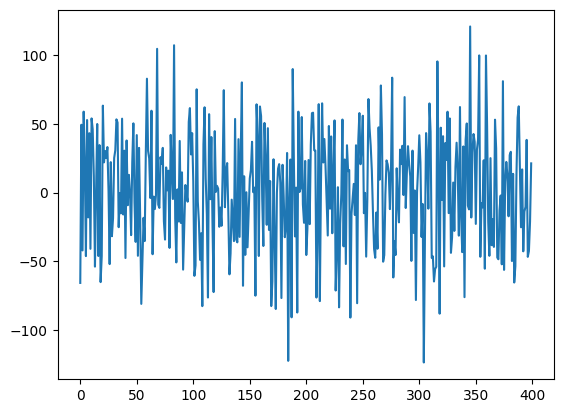

In [20]:
plt.plot(ts)

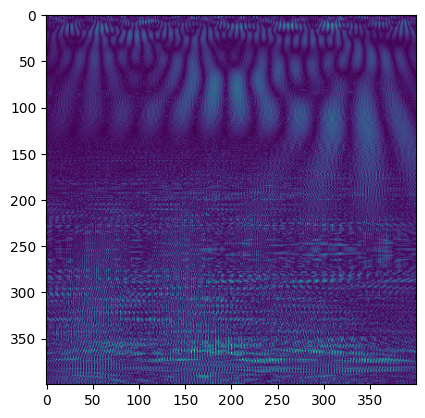

In [21]:
plt.imshow(wt(ts))